In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd drive/My\ Drive/Projects/TimeSeriesForecasting

/content/drive/My Drive/Projects/TimeSeriesForecasting


In [0]:
import os
import json
import numpy as np
import pandas as po
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [0]:
#from dtaidistance import dtw

In [5]:
import tensorflow as tf
from nbeats_model import NBeatsNet
import tensorflow.keras.backend as K

Using TensorFlow backend.


In [0]:
os.makedirs('model_checkpoints', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('Anomaly_Detection', exist_ok=True)

In [0]:
class weekday_args:
  def __init__(self):
    self.val_start = 12*24*150
    self.test_start = 12*24*200
    self.train_seq_len = 12*24*10
    self.val_seq_len = 12*24
    
    self.seasonality = 12*24
    self.batch_size = 1024
    self.num_epochs = 100
    self.hidden_dim = 75
    self.theta_1 = 25
    self.theta_2 = 37
    self.nb_blocks_per_stack = 1
    
    self.save_folder = 'weekday_forecast_NBEATS_anomaly'

In [0]:
args = weekday_args()

In [0]:
df = po.read_csv('data/2017_energy_5min_noTransform.csv')

In [0]:
scaler = MinMaxScaler()
df['W'] = scaler.fit_transform(df)

In [11]:
weekday_power_series = []
weekend_power_series = []
for i in tqdm(range(0, len(df)-7, 7*288)):
  weekday_power_series += df['W'][i:i+5*288].tolist()
  weekend_power_series += df['W'][i+5*288:i+7*288].tolist()
weekday_power_series = np.array(weekday_power_series)
weekend_power_series = np.array(weekend_power_series)

100%|██████████| 50/50 [00:00<00:00, 1658.55it/s]


In [0]:
os.makedirs('plots/' + args.save_folder, exist_ok=True)
os.makedirs('model_checkpoints/' + args.save_folder, exist_ok=True)
os.makedirs('model_checkpoints/' + args.save_folder + '/logs_dir', exist_ok=True)
os.makedirs('forecasts/full_testing_length/' + args.save_folder, exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder, exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder + '/plots', exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder + '/tabulated_results', exist_ok=True)

In [0]:
train_arr = weekday_power_series[: args.val_start]
val_arr = weekday_power_series[args.val_start: args.test_start]
test_arr = weekday_power_series[args.test_start:]

In [0]:
def make_windows(data, train_seq_len = args.train_seq_len, val_seq_len = args.val_seq_len):
    X = []
    y = []

    for i in tqdm(range(train_seq_len, len(data) - val_seq_len + 1)):    
        X.append(data[i - train_seq_len: i].T.tolist())
        y.append(data[i: i + val_seq_len].T.tolist())

    X = np.array(X).squeeze().reshape(-1, train_seq_len, 1)
    y = np.array(y).squeeze()

    return X, y

In [15]:
X_train, y_train = make_windows(train_arr)
X_val, y_val = make_windows(val_arr)
X_test, y_test = make_windows(test_arr)

100%|██████████| 11233/11233 [00:01<00:00, 6732.10it/s]


In [0]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

In [0]:
#sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-8, momentum=0.9, nesterov=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4)
#loss_funk = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

In [0]:
def pinball_loss(y_true, y_pred, tau):
    err = y_true - y_pred
    return K.mean(K.maximum(tau*err, (tau-1)*err), axis = -1)

In [0]:
loss_98 = lambda y_true, y_pred : pinball_loss(y_true, y_pred, 0.98)
loss_01 = lambda y_true, y_pred : pinball_loss(y_true, y_pred, 0.01)

In [23]:
model_98 = NBeatsNet(backcast_length = args.train_seq_len, forecast_length = args.val_seq_len,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=args.nb_blocks_per_stack,
                  thetas_dim = (args.theta_1, args.theta_2), share_weights_in_stack = True, hidden_layer_units = args.hidden_dim)
          
model_98.compile_model(loss=loss_98, learning_rate = 1e-3)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     (None, 2880, 1)      0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 2880)         0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/generic/d1 (Dense)          (None, 75)           216075      lambda_2[0][0]                   
__________________________________________________________________________________________________
0/0/generic/d2 (Dense)          (None, 75)           5700        0/0/generic/d1[0][0]             
____________________________________________________________________________________________

In [24]:
history_98 = model_98.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Train on 40033 samples, validate on 11233 samples
Epoch 1/100
40033/40033 [==============================] - 2s 46us/step - loss: 0.0812 - val_loss: 0.0082
Epoch 2/100
40033/40033 [==============================] - 1s 35us/step - loss: 0.0078 - val_loss: 0.0079
Epoch 3/100
40033/40033 [==============================] - 1s 36us/step - loss: 0.0071 - val_loss: 0.0079
Epoch 4/100
40033/40033 [==============================] - 1s 35us/step - loss: 0.0067 - val_loss: 0.0080
Epoch 5/100
40033/40033 [==============================] - 1s 35us/step - loss: 0.0062 - val_loss: 0.0068
Epoch 6/100
40033/40033 [==============================] - 1s 35us/step - loss: 0.0059 - val_loss: 0.0078
Epoch 7/100
40033/40033 [==============================] - 1s 35us/step - loss: 0.0054 - val_loss: 0.0066
Epoch 8/100
40033/40033 [==============================] - 1s 35us/step - loss: 0.0050 - val_loss: 0.0062
Epoch 9/100
40033/40033 [==============================] - 1s 35us/step - loss: 0.0047 - val_loss: 0.0

In [25]:
best_epoch = np.argmin(np.array(history_98.history['val_loss']))+1
model_98.save_weights('model_checkpoints/' + args.save_folder + '/model_u_{:02d}.h5'.format(best_epoch))
model_98.load_weights('model_checkpoints/' + args.save_folder + '/model_u_{:02d}.h5'.format(best_epoch))
best_epoch

18

In [0]:
y_pred_98 = model_98.predict(X_test)

In [27]:
model_01 = NBeatsNet(backcast_length = args.train_seq_len, forecast_length = args.val_seq_len,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=args.nb_blocks_per_stack,
                  thetas_dim = (args.theta_1, args.theta_2), share_weights_in_stack = True, hidden_layer_units = args.hidden_dim)
          
model_01.compile_model(loss=loss_01, learning_rate = 1e-3)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     (None, 2880, 1)      0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 2880)         0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/generic/d1 (Dense)          (None, 75)           216075      lambda_3[0][0]                   
__________________________________________________________________________________________________
0/0/generic/d2 (Dense)          (None, 75)           5700        0/0/generic/d1[0][0]             
____________________________________________________________________________________________

In [28]:
history_01 = model_01.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Train on 40033 samples, validate on 11233 samples
Epoch 1/100
40033/40033 [==============================] - 2s 47us/step - loss: 0.0029 - val_loss: 0.0019
Epoch 2/100
40033/40033 [==============================] - 1s 37us/step - loss: 0.0023 - val_loss: 0.0018
Epoch 3/100
40033/40033 [==============================] - 1s 37us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/100
40033/40033 [==============================] - 1s 37us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 5/100
40033/40033 [==============================] - 1s 37us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 6/100
40033/40033 [==============================] - 2s 38us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 7/100
40033/40033 [==============================] - 2s 38us/step - loss: 0.0019 - val_loss: 0.0017


In [29]:
best_epoch = np.argmin(np.array(history_01.history['val_loss']))+1
model_01.save_weights('model_checkpoints/' + args.save_folder + '/model_l_{:02d}.h5'.format(best_epoch))
model_01.load_weights('model_checkpoints/' + args.save_folder + '/model_l_{:02d}.h5'.format(best_epoch))
best_epoch

3

In [0]:
y_pred_01 = model_01.predict(X_test)

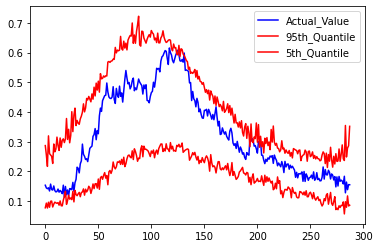

In [31]:
plt.plot(y_test[0], color = 'blue')
plt.plot(y_pred_98[0], color = 'red')
plt.plot(y_pred_01[0], color = 'red')
plt.legend(['Actual_Value', '95th_Quantile', '5th_Quantile'])
#plt.savefig('plots/' + args.save_folder + '/test_weekend_pred.png')

In [41]:
forecasts_98 = []
forecasts_01 = []
actuals = []
for i in tqdm(range(y_pred_98.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts_98 += (scaler.inverse_transform(y_pred_98[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  forecasts_01 += (scaler.inverse_transform(y_pred_01[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  actuals += (scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()

100%|██████████| 39/39 [00:00<00:00, 1633.62it/s]


In [0]:
l = np.array([a - f_01 for a, f_01 in zip(actuals, forecasts_01)])
l_t = np.where(l < 0, actuals, None)
l_picp = np.where(l < 0, 0, 1)

In [0]:
r = np.array([f_98 - a for f_98, a in zip(forecasts_98, actuals)])
r_t = np.where(r < 0, actuals, None)
r_picp = np.where(r < 0, 0, 1)

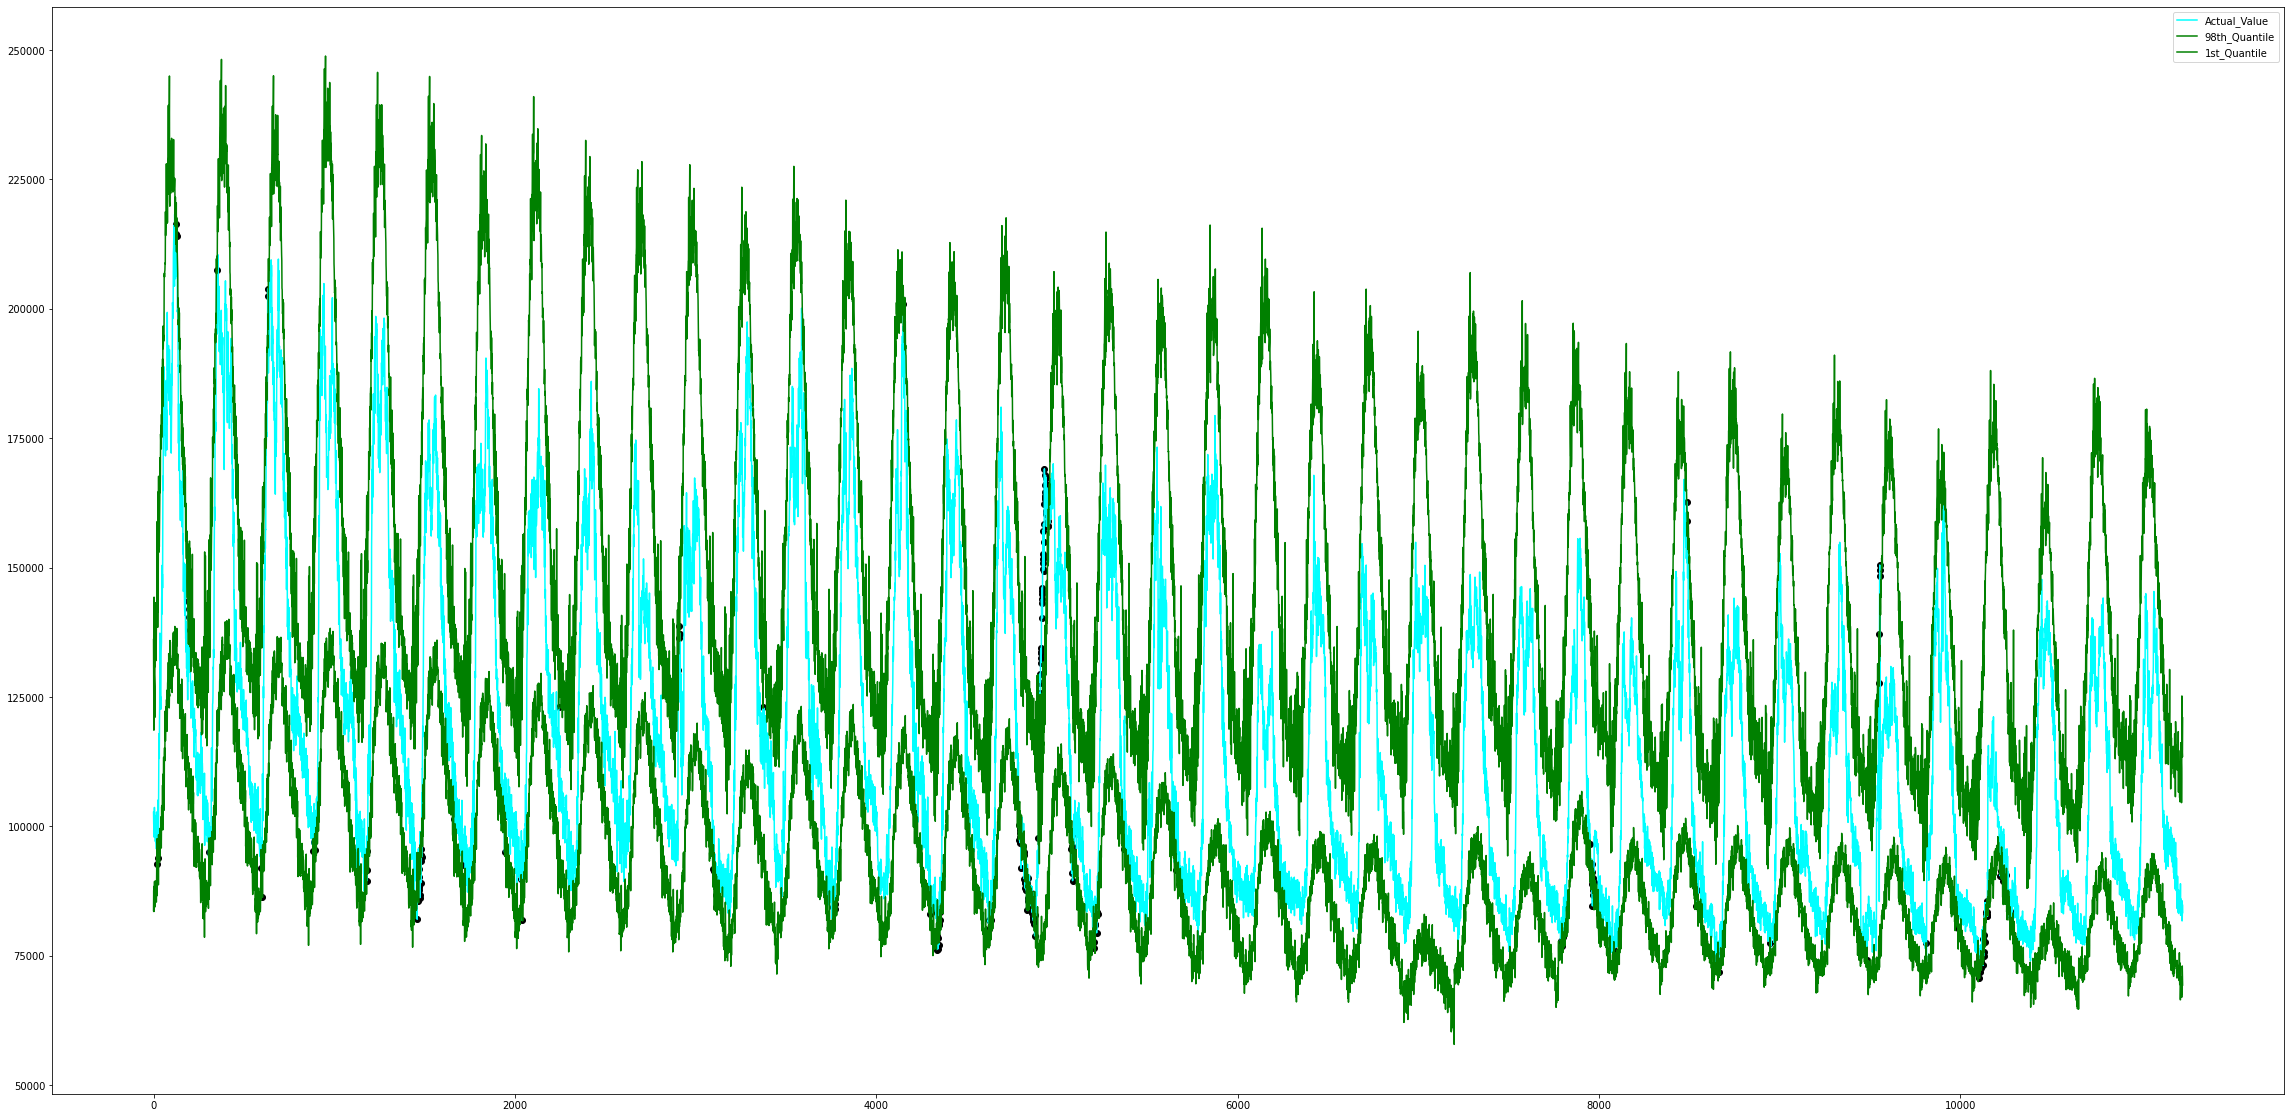

In [74]:
plt.figure(figsize=(40, 20))
plt.plot(actuals, color = 'cyan')
plt.plot(forecasts_98, color = 'green')
plt.plot(forecasts_01, color = 'green')
plt.scatter(range(len(l_t)), l_t, color = 'black')
plt.scatter(range(len(r_t)), r_t, color = 'black')
plt.legend(['Actual_Value', '98th_Quantile', '1st_Quantile'])
plt.savefig('Anomaly_Detection' + '/anomalies_quantiles.png')

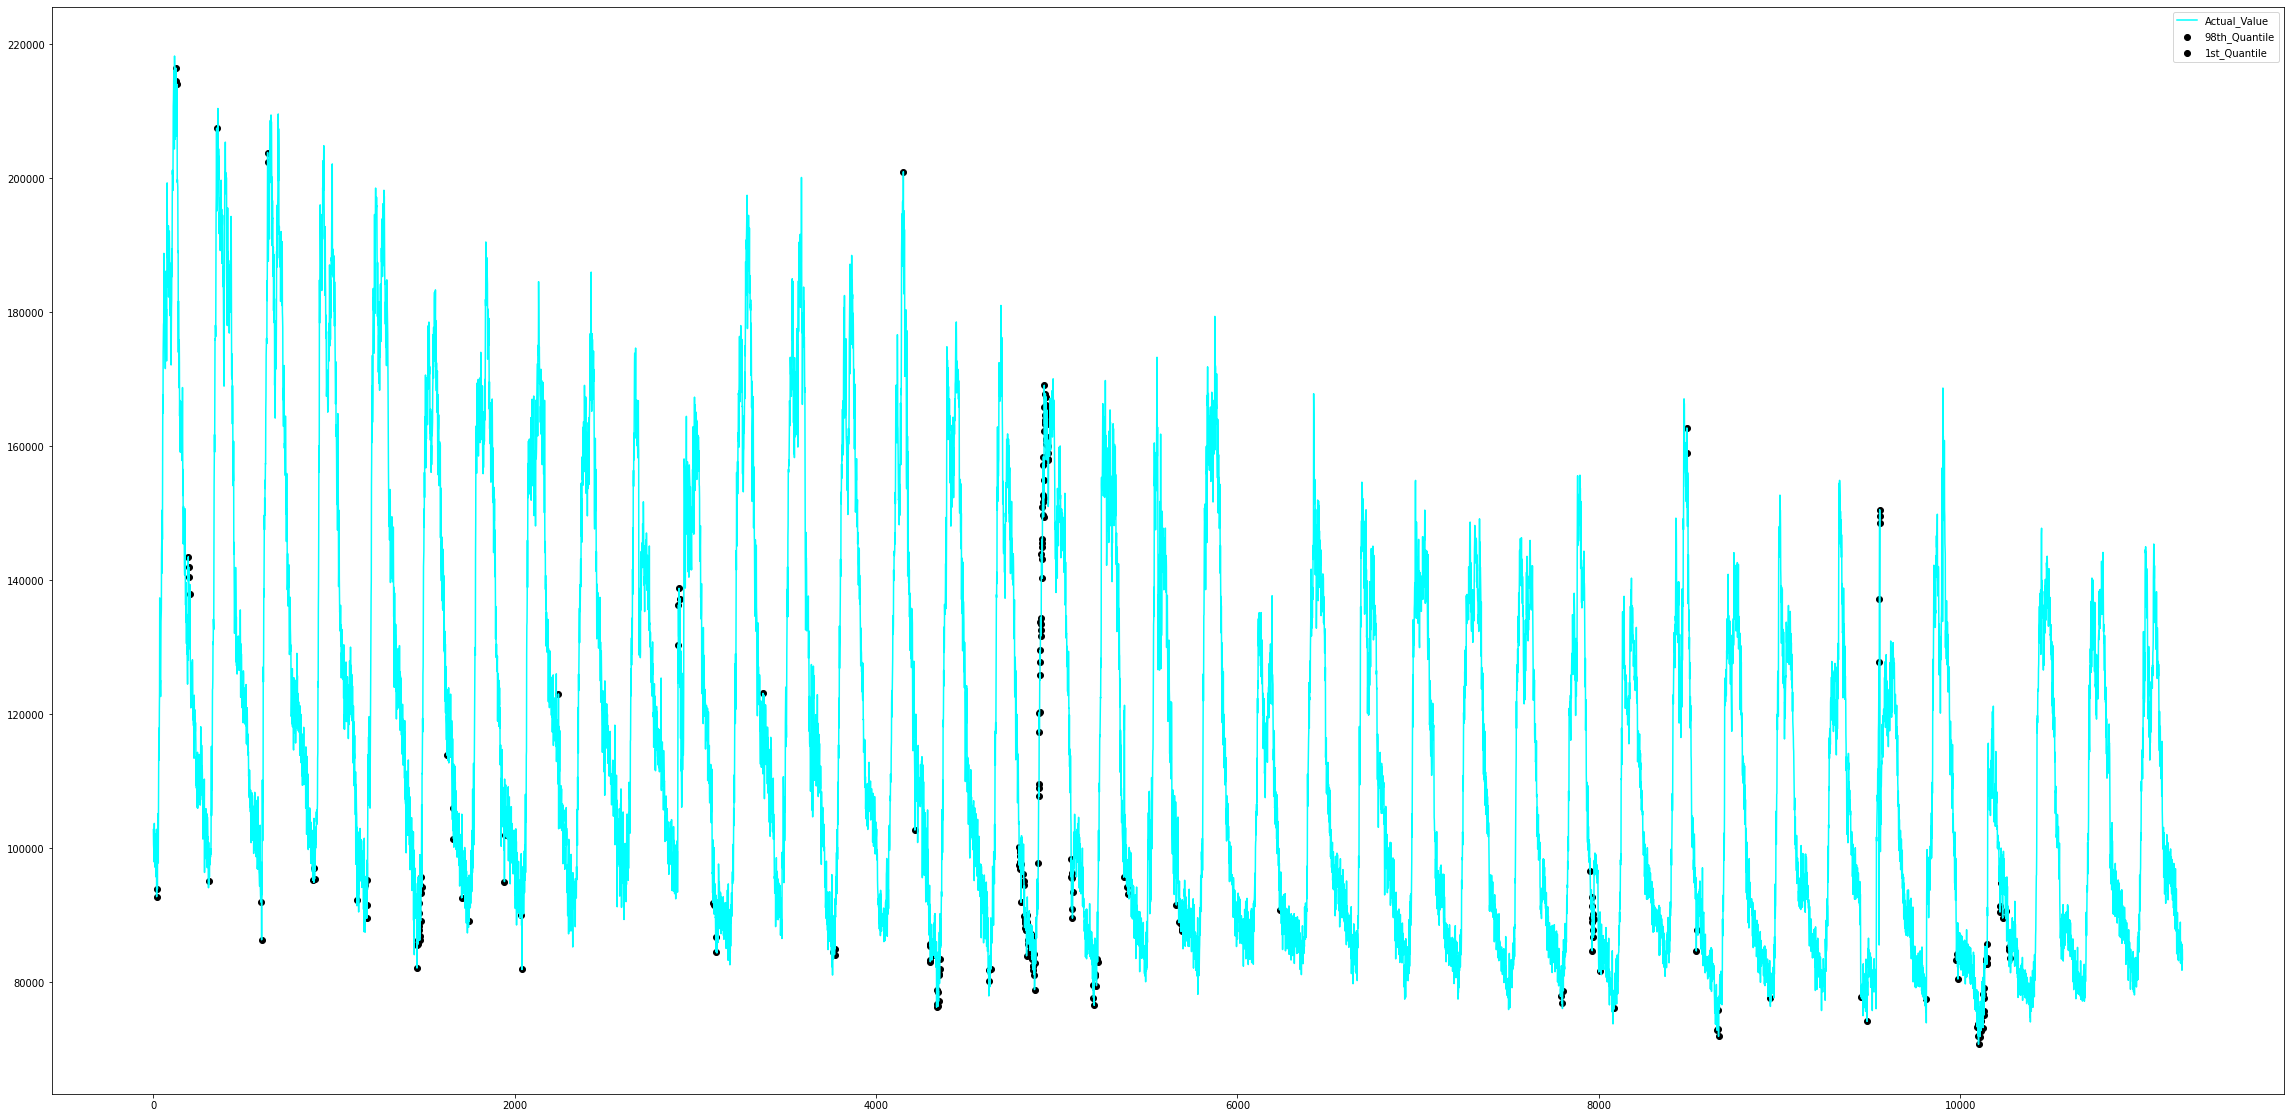

In [75]:
plt.figure(figsize=(40, 20))
plt.plot(actuals, color = 'cyan')
#plt.plot(forecasts_95, color = 'green')
#plt.plot(forecasts_05, color = 'green')
plt.scatter(range(len(l_t)), l_t, color = 'black')
plt.scatter(range(len(r_t)), r_t, color = 'black')
plt.legend(['Actual_Value', '98th_Quantile', '1st_Quantile'])
plt.savefig('Anomaly_Detection/' + 'anomalies.png')

In [66]:
PICP = (np.sum(l_picp) + np.sum(r_picp))/(len(l_picp) + len(r_picp))
PICP

0.9878472222222222

In [0]:
E = np.array(actuals).max() - np.array(actuals).min()
N = len(actuals)

In [0]:
u_l = np.array([f_98 - f_01 for f_98, f_01 in zip(forecasts_98, forecasts_01)])

In [68]:
PINAW = np.sum(u_l)/(N*E)
PINAW

0.3931603366011067